In [13]:
import matplotlib.pyplot as plt 
import json
from glob import glob

from collections import defaultdict
import os
import numpy as np

import pandas as pd


dataset_names=[	    
        'adult',
	    'electricity',
	    'forest_cover',
	    'hyperplane_high_gradual_drift',
	    'insects',
	    'movingRBF',
	    'moving_squares',
	    'new_airlines',
	    'sea_high_abrupt_drift',
	    'sea_high_mixed_drift',
	    'shuttle',
	    'synth_RandomRBFDrift',
	    'synth_agrawal',
	    'vehicle_sensIT',
      'rialto',
      'weather',
      'river_Waveform_2',
      'river_anomalysine',
      'river_Waveform',
      'skmul_aggrawal',
      'skmul_anomalysine_2',
      'river_hyperlane_2',
      'skmul_anomalysine',
      'river_hyperlane',
      'skmul_hyperlane',
      'river_led   #ASML',
      'skmul_ledgenerator',
      'river_led_default_drift',
      'skmul_ledgenerator_default_drift',
      'river_mixed',
      'skmul_randomRBF_default_drift',
      'river_SEA_2',
      'skmul_randomRBF_gradual',
      'skmul_randomTree_2',
      'river_randomRBF_2 #OAML',
      'skmul_randomTree',
      'river_randomRBF',
      'river_randomRBF_drift',
      'skmul_SEA_2',
      'river_randomTree_2',
      'skmul_SEA',
      'river_randomTree',
      'skmul_Sine',
      'river_SEA',
      'skmul_STAGGER_2',
      'river_SINE',
      'skmul_STAGGER',
      'river_STAGGER',
      'skmul_Waveform',
      'river_aggrawal'

]


model_names=('HATC','ARFC','AutoClass','AutoStreamML','SRPC', 'EvoAutoML',"OnlineAutoML")
# model_names=('ARFC','AutoStreamML','SRPC', 'HATC')

dataset_by_model={}
for dataset in dataset_names:
    dataset_by_model[dataset]={}

for model in model_names:
    for dataset in dataset_names:
        dataset_by_model[dataset][model]=glob(f'./experiment-results/{model}/{model}_{dataset}*')

# Mann-Kendall test

In [14]:

import pymannkendall as mk
import json
import numpy as np
from utils import downsample


def run_mann_kendall_tests(data_type: str):
    """
    Runs Mann-Kendall trend tests on all datasets and models for the given data_type.

    Args:
        data_type (str): Either 'time' or 'energy_consumed'.
    """
    assert data_type in ['time', 'energy_consumed'], "data_type must be 'time' or 'energy_consumed'"

    default_config = True

    def get_energy(path, data_type):
        with open(path, 'r') as file:
            data = json.load(file)
        data = np.array(data[data_type])
        data = downsample(data, 100)
        return data

    def do_mann_kendall_for_sample(sample_path, data_type):
        data = get_energy(sample_path, data_type)
        return mk.original_test(data)

    mann_kendall_dict = {}

    for model in model_names:
        for dataset in dataset_names:
            mann_kendall_dict.setdefault(dataset, {})[model] = []
            for sample in dataset_by_model[dataset][model]:
                if default_config:
                    if model == 'AutoClass' and 'population_size_10_exploration_window_1000' not in sample:
                   
                        continue
                    if model == 'AutoStreamML' and 'exploration_window_1000_ensemble_size_3_budget_10' not in sample:
                   
                        continue
                    if model == 'EvoAutoML' and 'population_size_10_sampling_size_1_sampling_rate_1000' not in sample:
                   
                        continue
                    if model == 'OnlineAutoML' and 'default' not in sample:

                        continue
                    if model in ['SRPC', 'ARFC', 'HATC'] and 'nmodel_3' not in sample:

                        continue

                result = do_mann_kendall_for_sample(sample, data_type)
                mann_kendall_dict[dataset][model].append(result)
        

    
    return mann_kendall_dict


In [16]:
results_time = run_mann_kendall_tests('time')
results_energy = run_mann_kendall_tests('energy_consumed')


In [17]:
import pandas as pd

def mann_kendall_to_dataframe(mann_kendall_dict): #Convert above run into pandas

    records = []
    for dataset, models in mann_kendall_dict.items():
        for model, results in models.items():
            for i, res in enumerate(results):
                records.append({
                    "dataset": dataset,
                    "model": model,
                    "trend": res.trend,
                    "h": res.h,
                    "p_value": res.p,
                    "z": res.z,
                    "Tau": res.Tau,
                    "s": res.s,
                    "var_s": res.var_s,
                    "slope": res.slope,
                    "intercept": res.intercept
                })
    
    df = pd.DataFrame(records)
    return df

In [18]:
results_time_df = mann_kendall_to_dataframe(results_time)
results_energy_df = mann_kendall_to_dataframe(results_energy)


In [19]:
results_time_df.to_csv('./mann_kendall_time.csv')
results_energy_df.to_csv('./mann_kendall_energy.csv')

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_mann_kendall_results(mann_kendall_results, data_type: str):



    #Scaling slopes 
    scale_factor = 1000 if data_type == 'time' else 3600000
    mann_kendall_results["slope_scaled"] = mann_kendall_results["slope"] * scale_factor


    model_names_for_stats = ('AutoClass', 'AutoStreamML', 'EvoAutoML', 
                             'OnlineAutoML','ARFC','HATC','SRPC')

    # --- Custom colors (one per model, same length as order) ---
    custom_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", 
                      "#d62728", "#9467bd", "#8c564b", "#e377c2"]

    # --- Boxplot ---
    plt.figure(figsize=(8,5))
    sns.boxplot(
        data=mann_kendall_results,
        x="model",
        y="slope_scaled",
        order=model_names_for_stats,
        palette=custom_palette,
        showfliers=False,
    )

    plt.ylabel("Sen's Slope", fontsize=15)
    plt.xlabel("Framework", fontsize=15)

    # Custom x-ticks (replace AutoStreamML -> ASML)
    xticklabels = [lbl.replace("AutoStreamML", "ASML") for lbl in model_names_for_stats]
    plt.xticks(
        ticks=range(len(model_names_for_stats)),
        labels=xticklabels,
        rotation=20,
        fontsize=12
    )

    plt.yticks(fontsize=12) 
    plt.tight_layout()
    plt.grid(True, axis="y")
    plt.show()


/tmp/ipykernel_10771/2655965227.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


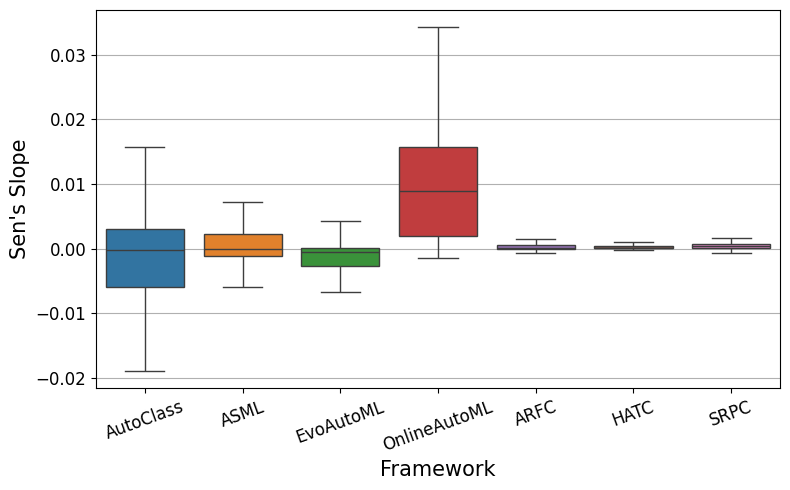

/tmp/ipykernel_10771/2655965227.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


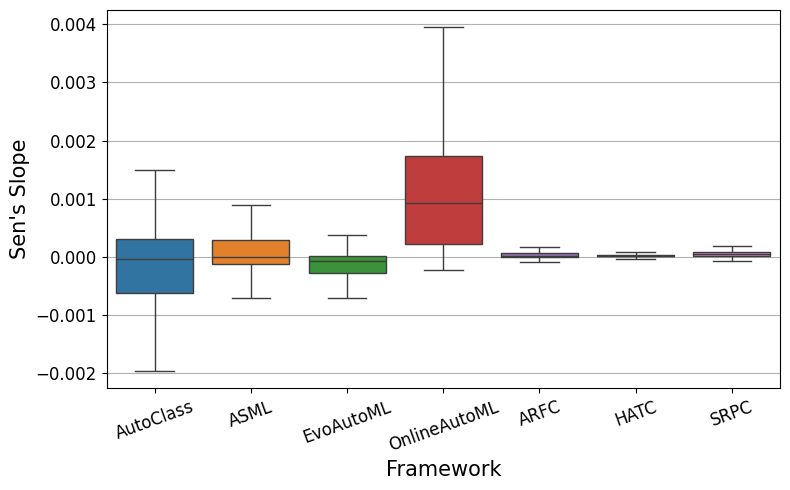

In [21]:
plot_mann_kendall_results(results_time_df, 'time')
plot_mann_kendall_results(results_energy_df, 'energy_consumed')

# AFD test(removed)


In [22]:
import json
import numpy as np
from statsmodels.tsa.stattools import adfuller
from multiprocessing import Pool, cpu_count
from functools import partial
import pandas as pd

# Configuration
CHUNK_SIZE = 1000  # Averaging window
ALPHA = 0.05       # Significance level
N_PROCESSES = 4  # Leave 1 core free

metric='time'

def process_single_run(run_path, chunk_size=CHUNK_SIZE, alpha=ALPHA):
    """Process one run file and return stationarity result"""
    try:
        with open(run_path) as f:
            data = json.load(f)
            if metric =='time':
                time = np.array(data[metric]) * 1000  # or 'time' for latency
            if metric =='energy_consumed':
                time = np.array(data[metric]) * 3600000
        
        # Chunk averaging
        num_chunks = len(time) // chunk_size
        if num_chunks < 1:
            return {'path': run_path, 'error': f"Insufficient data (<{chunk_size} samples)"}
            
        averaged = time[:num_chunks * chunk_size].reshape(-1, chunk_size).mean(axis=1)
        
        # ADF test
        adf_result = adfuller(averaged, autolag='AIC')
        return {
            'path': run_path,
            'adf_statistic': adf_result[0],
            'p_value': adf_result[1],
            'is_stationary': adf_result[1] < alpha,
            'critical_values': adf_result[4]
        }
    except Exception as e:
        return {'path': run_path, 'error': str(e)}

def analyze_model(model_runs):
    """Parallel processing of all runs for one model"""
    with Pool(processes=N_PROCESSES) as pool:
        results = pool.map(process_single_run, model_runs)
    return results

# Main analysis
full_results = {}
for dataset, models in dataset_by_model.items():
    full_results[dataset] = {}
    for model, runs in models.items():
        full_results[dataset][model] = analyze_model(runs)

# Generate summary report
summary = []
for dataset, models in full_results.items():
    for model, runs in models.items():
        successful_runs = [r for r in runs if 'is_stationary' in r]
        if not successful_runs:
            continue
            
        stationary_count = sum(r['is_stationary'] for r in successful_runs)
        summary.append({
            'Dataset': dataset,
            'Model': model,
            'Stationary Runs': stationary_count,
            'Total Runs': len(successful_runs),
            'Stationary Rate': f"{100 * stationary_count / len(successful_runs):.1f}%",
            'Avg p-value': f"{np.mean([r['p_value'] for r in successful_runs]):.3f}"
        })

# Save results
pd.DataFrame(summary).to_csv(f'downsized_results_csv/stationarity_report_{metric}.csv', index=False)
